# 3D slices

Simple pure matplotlib figure to slice through a 3D volume interactively.

An improved, maintained version can be found in [discretize](https://github.com/simpeg/discretize).

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
plt.style.use('ggplot')
%matplotlib notebook

In [3]:
def plot_interactive(data, xslice=None, yslice=None, zslice=None, clim=None,
                     pcolorOpts=None):
    """Plot slices of a 3D volume, interactively.

    data :: dict containing data; needs the following keywords:
        - data : the actual data.
        - xc, yc, zc : center points of cells.
        - xx, yy, zz : edges of cells (have to have one element more then
                       corresponding centers).

    xslice, yslice, zslice: Initial slice locations (in axis units).
            Optional; defaults to the middle of the volume.

    """

    class IndexTracker():
        def __init__(self, data, xslice, yslice, zslice, clim, pcolorOpts):
            """Initialize interactive figure."""

            # 1. Store relevant data

            # Store data
            self.data = data['data'].copy()

            # Axis
            self.x = data['xx']
            self.y = data['yy']
            self.z = data['zz']
            self.xc = data['xc']
            self.yc = data['yc']
            self.zc = data['zc']

            # Store initial slice indices
            if xslice:
                self.xind = np.argmin(np.abs(self.xc - xslice))
            else:
                self.xind = data['xc'].size // 2
            if xslice:
                self.yind = np.argmin(np.abs(self.yc - yslice))
            else:
                self.yind = data['yc'].size // 2
            if zslice:
                self.zind = np.argmin(np.abs(self.zc - zslice))
            else:
                self.zind = data['zc'].size // 2

            # 2. Start figure

            # Create subplots
            self.fig = plt.gcf()
            self.fig.subplots_adjust(wspace=.075, hspace=.1)

            # X-Y
            self.ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=2)
            self.ax1.set_ylabel('y-axis (units)')
            self.ax1.xaxis.set_ticks_position('top')
            plt.setp(self.ax1.get_xticklabels(), visible=False)

            # X-Z
            self.ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=2,
                                        sharex=self.ax1)
            self.ax2.yaxis.set_ticks_position('both')
            self.ax2.invert_yaxis()
            self.ax2.set_xlabel('x-axis (units)')
            self.ax2.set_ylabel('z-axis (units)')

            # Z-Y
            self.ax3 = plt.subplot2grid((3, 3), (0, 2), rowspan=2,
                                        sharey=self.ax1)
            self.ax3.yaxis.set_ticks_position('right')
            self.ax3.xaxis.set_ticks_position('both')
            plt.setp(self.ax3.get_yticklabels(), visible=False)

            # Title
            fig.suptitle('Scroll with your mouse\nwhile hoovering over the '
                         +'subplot you want to slice through.')

            # Cross-line properties
            # We have to lines, a thick white one, and in the middle a thin black
            # one, to assure that the lines can be seen on dark and on bright
            # spots.
            self.clpropsw = {'c': 'w', 'lw': 2, 'zorder': 10}
            self.clpropsk = {'c': 'k', 'lw': 1, 'zorder': 11}

            # Store min and max of all data
            if clim is None:
                clim = [np.nanmin(self.data), np.nanmax(self.data)]
            self.pc_props = {'vmin': clim[0], 'vmax': clim[1]}

            # Add pcolorOpts
            if pcolorOpts is not None:
                self.pc_props.update(pcolorOpts)

            # Initial draw
            self.update_xy()
            self.update_xz()
            self.update_zy()

            # Create colorbar
            plt.colorbar(self.zy_pc, pad=0.15)

            # 3. Keep depth in X-Z and Z-Y in sync

            def do_adjust():
                """Return True if z-axis in X-Z and Z-Y are different."""
                one = np.array(self.ax2.get_ylim())
                two = np.array(self.ax3.get_xlim())[::-1]
                return sum(abs(one - two)) > 0.001  # Difference at least 1 m.

            def on_ylims_changed(ax):
                """Adjust Z-Y if X-Z changed."""
                if do_adjust():
                    self.ax3.set_xlim([self.ax2.get_ylim()[1],
                                       self.ax2.get_ylim()[0]])

            def on_xlims_changed(ax):
                """Adjust X-Z if Z-Y changed."""
                if do_adjust():
                    self.ax2.set_ylim([self.ax3.get_xlim()[1],
                                       self.ax3.get_xlim()[0]])

            self.ax3.callbacks.connect('xlim_changed', on_xlims_changed)
            self.ax2.callbacks.connect('ylim_changed', on_ylims_changed)

        def onscroll(self, event):
            """Update index and data when scrolling."""

            # Get scroll direction
            if event.button == 'up':
                pm = 1
            else:
                pm = -1

            # Update slice index depending on subplot over which mouse is
            if event.inaxes == self.ax1:    # X-Y
                self.zind = (self.zind + pm) % (self.zc.size - 1)
                self.update_xy()
            elif event.inaxes == self.ax2:  # X-Z
                self.yind = (self.yind + pm) % (self.yc.size - 1)
                self.update_xz()
            elif event.inaxes == self.ax3:  # Z-Y
                self.xind = (self.xind + pm) % (self.xc.size - 1)
                self.update_zy()

            plt.draw()

        def update_xy(self):
            """Update plot for change in Z-index."""

            # Clean up
            self._clear_elements(['xy_pc', 'xz_ahw', 'xz_ahk', 'zy_avw', 'zy_avk'])

            # Draw X-Y slice
            zdat = self.data[:, :, self.zind].transpose()
            self.xy_pc = self.ax1.pcolormesh(self.x, self.y, zdat, **self.pc_props)

            # Draw Z-slice intersection in X-Z plot
            self.xz_ahw = self.ax2.axhline(self.zc[self.zind], **self.clpropsw)
            self.xz_ahk = self.ax2.axhline(self.zc[self.zind], **self.clpropsk)

            # Draw Z-slice intersection in Z-Y plot
            self.zy_avw = self.ax3.axvline(self.zc[self.zind], **self.clpropsw)
            self.zy_avk = self.ax3.axvline(self.zc[self.zind], **self.clpropsk)

        def update_xz(self):
            """Update plot for change in Y-index."""

            # Clean up
            self._clear_elements(['xz_pc', 'zy_ahk', 'zy_ahw', 'xy_ahk', 'xy_ahw'])

            # Draw X-Z slice
            ydat = self.data[:, self.yind, :].transpose()
            self.xz_pc = self.ax2.pcolormesh(self.x, self.z, ydat, **self.pc_props)

            # Draw X-slice intersection in X-Y plot
            self.xy_ahw = self.ax1.axhline(self.yc[self.yind], **self.clpropsw)
            self.xy_ahk = self.ax1.axhline(self.yc[self.yind], **self.clpropsk)

            # Draw X-slice intersection in Z-Y plot
            self.zy_ahw = self.ax3.axhline(self.yc[self.yind], **self.clpropsw)
            self.zy_ahk = self.ax3.axhline(self.yc[self.yind], **self.clpropsk)

        def update_zy(self):
            """Update plot for change in X-index."""

            # Clean up
            self._clear_elements(['zy_pc', 'xz_avw', 'xz_avk', 'xy_avw', 'xy_avk'])

            # Draw Z-Y slice
            xdat = self.data[self.xind, :, :]
            self.zy_pc = self.ax3.pcolormesh(self.z, self.y, xdat, **self.pc_props)

            # Draw Y-slice intersection in X-Y plot
            self.xy_avw = self.ax1.axvline(self.xc[self.xind], **self.clpropsw)
            self.xy_avk = self.ax1.axvline(self.xc[self.xind], **self.clpropsk)

            # Draw Y-slice intersection in X-Z plot
            self.xz_avw = self.ax2.axvline(self.xc[self.xind], **self.clpropsw)
            self.xz_avk = self.ax2.axvline(self.xc[self.xind], **self.clpropsk)

        def _clear_elements(self, names):
            """Remove elements from list <names> from plot if they exists."""
            for element in names:
                if hasattr(self, element):
                    getattr(self, element).remove()

    # Figure
    fig = plt.figure()

    tracker = IndexTracker(data, xslice, yslice, zslice, clim, pcolorOpts)
    fig.canvas.mpl_connect('scroll_event', tracker.onscroll)

    plt.show()

<IPython.core.display.Javascript object>


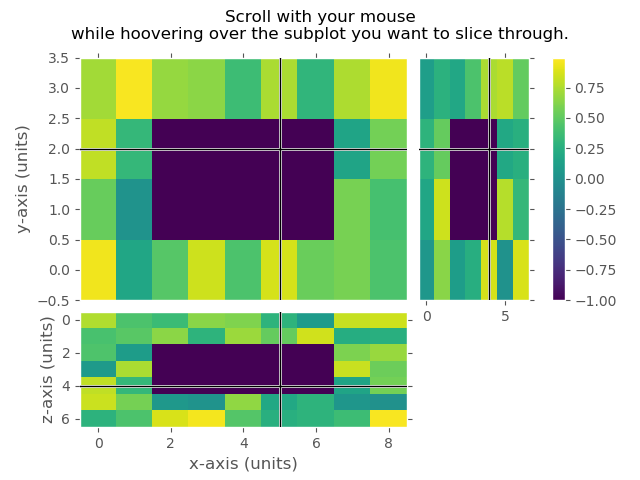

In [4]:
# Create some dummy data (can be an irregularly spaced grid),
# therefore we have to provide cell centers and edges.
nx, ny, nz = 10, 5, 8  # Number of cells in x, y, z direction

# Random numbers
dat = np.random.random(nx*ny*nz).reshape((nx, ny, nz))
dat[2:-3, 1:-2, 2:-3] = -1  # Add a block in the middle

data = {
    'xc': np.arange(nx),      # cell centers in x-direction
    'yc': np.arange(ny),      # cell centers in y-direction
    'zc': np.arange(nz),      # cell centers in z-direction
    'xx': np.arange(nx)-0.5,  # cell edges in x-direction
    'yy': np.arange(ny)-0.5,  # cell edges in y-direction
    'zz': np.arange(nz)-0.5,  # cell edges in z-direction
    'data': dat
}

# Plot the model
plot_interactive(data)